## Imports

In [160]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import pandas as pd
import json
import joblib

# feature_importance
import shap

# models
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split
)

# utils
import os
from ppm.nodes.metrics_calculator import (
    metrics_calculate,
    show_results
)
from ppm.nodes.cross_validation import (
    cross_validation
)
from ppm.nodes.process_outputs import (
    ranking_output
)
from ppm.nodes.feature_explainer import (
    tree_explainer,
    shap_explainer
)
from ppm.nodes.plots import (
    plot_feature_importance,
    plot_predictions,
    plot_true_vs_pred
)

## Parameters

In [161]:
path_root = os.path.join("..","data")

path_primary = os.path.join(
    path_root, "03_primary"
)
path_model = os.path.join(
    path_root, "04_model"
)
path_encoders = os.path.join(
    path_model, "encoders"
)
path_model_final = os.path.join(
    path_model, "model"
)

file_path_input_data = os.path.join(
    path_primary, "data_not_outliers.csv"#"data_input.csv"
)

file_path_metrics_features_test = os.path.join(
    path_primary, "features_test_metrics.json"
)
file_path_metrics_features_selected = os.path.join(
    path_primary, "features_selected.json"
)
file_path_best_params = os.path.join(
    path_model, "best_params.json"
)
file_path_encoder_order = os.path.join(
    path_encoders, "encoders_orders.csv"
)
file_path_not_outliers = os.path.join(
    path_primary, "data_not_outliers.csv"
)

In [186]:
number_of_instances = -1

## Read content

In [208]:
data_input = pd.read_csv(
    file_path_not_outliers, # file_path_input_data, file_path_not_outliers
    index_col = 0
).head(number_of_instances)

In [210]:
encoders_order = pd.read_csv(
    file_path_encoder_order
)

In [211]:
# read encoders
encoders = {}
for encoder_content in encoders_order.values:
    encoder_name, encoder_url = encoder_content
    encoders[encoder_name.split(".")[0]] = joblib.load(
        encoder_url
    )

In [212]:
# read model pycaret
model = {}
for model_name in os.listdir(path_model_final):
    model[model_name.split(".")[0]] = joblib.load(
        os.path.join(
            path_model_final,
            model_name
        )
    )

In [213]:
if os.path.exists(file_path_metrics_features_selected):
    with open(file_path_metrics_features_selected, 'r') as json_file:
        features_selected = json.load(json_file)
    features_selected = features_selected["selected_features"]

In [214]:
if os.path.exists(file_path_best_params):
    with open(file_path_best_params, 'r') as json_file:
        best_params = json.load(json_file)
    best_params = best_params["params"]
else:
    best_params = {
        "random_state": 42
    }

In [215]:
estimator = model["actual_estimator"]

## Train test and split

In [216]:
target = [
    "price"
]
cd_setor_drop = [
    "cd_setor",
]
id_drop = [
    "ID"
]
cols_drop = cd_setor_drop + target

In [217]:
X = data_input[id_drop + features_selected].copy()

y = data_input[id_drop + target].copy()

In [218]:
X_oos_n1, X_oos_n2, y_oos_n1, y_oos_n2 = train_test_split(X,
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = best_params["random_state"])

## Encoders process

In [222]:
encoded_data = {
    "oos_n1": X_oos_n1.copy(),
    "oos_n2": X_oos_n2.copy()
}
for encoder_name, encoder_content in encoders.items():
    print("--- encoder: [{}]".format(encoder_name))
    for type_name, data_to_encoder in encoded_data.items():
        id_row = data_to_encoder[id_drop[0]].values
        data_to_encoder.drop(id_drop[0], axis = 1, inplace = True)
        encoded_data[type_name] = encoder_content.transform(data_to_encoder)
        encoded_data[type_name].insert(0, id_drop[0], id_row)

--- encoder: [numerical_imputer]
--- encoder: [categorical_imputer]
--- encoder: [clean_column_names]


## Metrics

In [223]:
y_oos_n1_preds = estimator.predict(encoded_data['oos_n1'].drop(id_drop, axis = 1))
y_oos_n2_preds = estimator.predict(encoded_data['oos_n2'].drop(id_drop, axis = 1))

In [226]:
args_oos_n2 = [
    y_oos_n2[target[0]].values,
    y_oos_n2_preds
]
args_oos_n1 = [
    y_oos_n1[target[0]].values,
    y_oos_n1_preds
]

metrics_oos_n2 = metrics_calculate(args_oos_n2)
metrics_oos_n1 = metrics_calculate(args_oos_n1)

metrics_oos_n1 = show_results(metrics_oos_n1, "oos_n1")
metrics_oos_n2 = show_results(metrics_oos_n2, "oos_n2")
metrics_results = metrics_oos_n1|metrics_oos_n2

-------- [ oos_n1 ] ----------
r2 : 0.9441
mape : 0.0901
rmse : 53880.0851
mse : 2903063573.6559
mae : 35490.031
median_ae : 21741.4342
correlation : 0.974
size : 1482
-------- [ oos_n2 ] ----------
r2 : 0.9392
mape : 0.0878
rmse : 51964.3688
mse : 2700295629.2437
mae : 33917.0365
median_ae : 19239.2448
correlation : 0.9703
size : 371


In [227]:
data_values = {}
for name, args in zip(['oos_n1', 'oos_n2'], [args_oos_n1, args_oos_n2]):
    content = ranking_output(args)
    data_values[name] = content

In [228]:
data_values['oos_n1'].filter(regex = r"y_*").corr()

,y_true,y_pred
y_true,1.000000,0.973977
y_pred,0.973977,1.000000


In [229]:
data_values['oos_n2'].filter(regex = r"rank_*").corr()

,rank_true,rank_pred
rank_true,1.000000,0.969902
rank_pred,0.969902,1.000000


## Cross validation

In [230]:
cv_results = cross_validation(
    X = X.drop(id_drop, axis=1).copy(),
    y = y.drop(id_drop, axis=1).copy(), 
    model = [estimator],
    cv_splits = 5,
    random_state = best_params["random_state"],
    show = True
)

5it [00:21,  4.33s/it]

--------------------
rmse: 128907.75745
rmse_std: 8904.48667
--------------------
--------------
r2: 0.66723
r2_std: 0.0478
--------------
-----------------
mape: 0.22244
mape_std: 0.02014
-----------------
-------------------------
mse: 16696499812.50634
mse_std: 2345760428.73451
-------------------------
-------------------------
median_ae: 52819.25289
median_ae_std: 5026.80571
-------------------------
-------------------
mae: 86461.36559
mae_std: 6105.31124
-------------------


## Feature importances

In [231]:
feature_importances, features_selected = tree_explainer(
    model = [estimator],
    features_names = list(X.drop(id_drop, axis=1).columns),
    n_features = 10
)

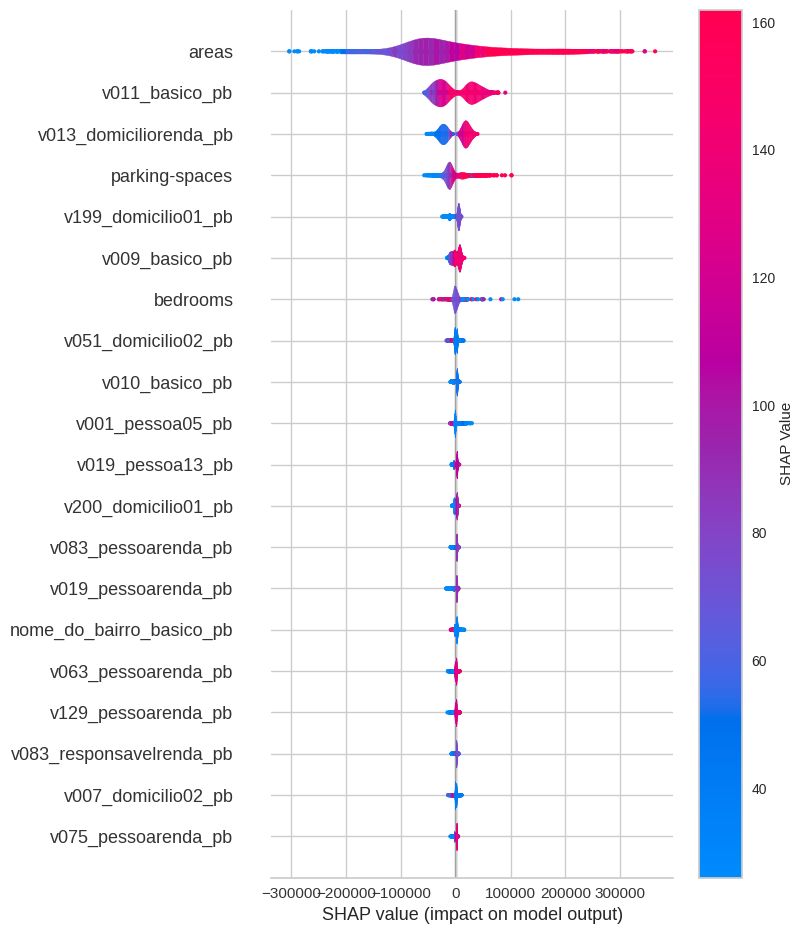

In [232]:
fig_shap, explainer = shap_explainer(
    [estimator],
    X_oos_n1.drop(id_drop, axis = 1)
)

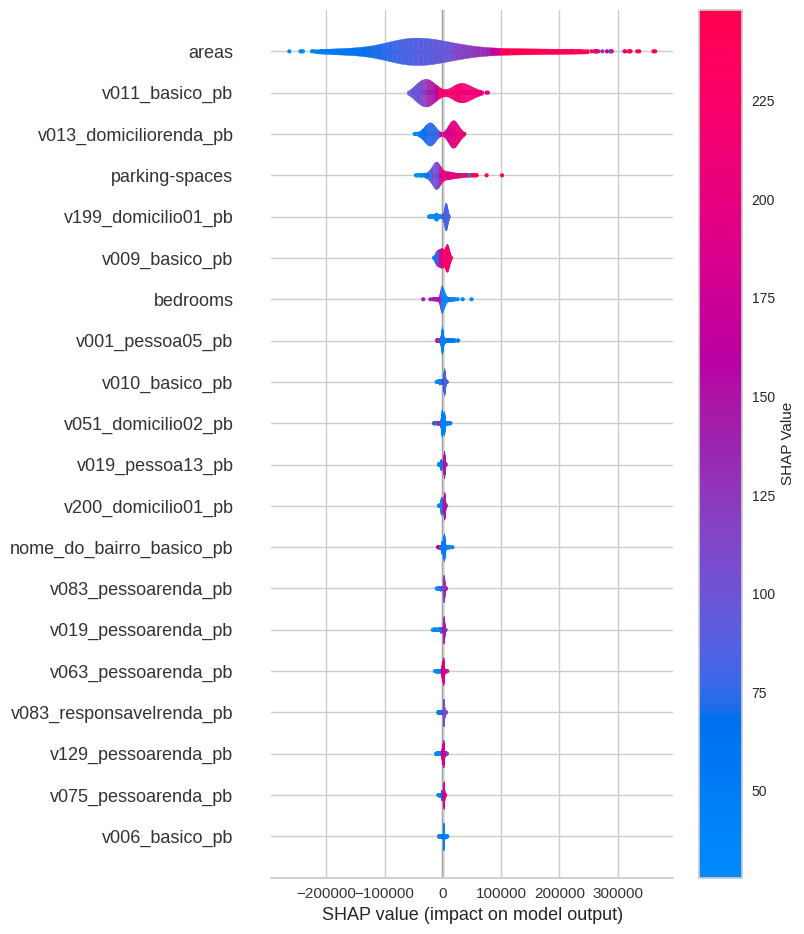

In [233]:
fig_shap, explainer = shap_explainer(
    [estimator],
    X_oos_n2.drop(id_drop, axis = 1)
)

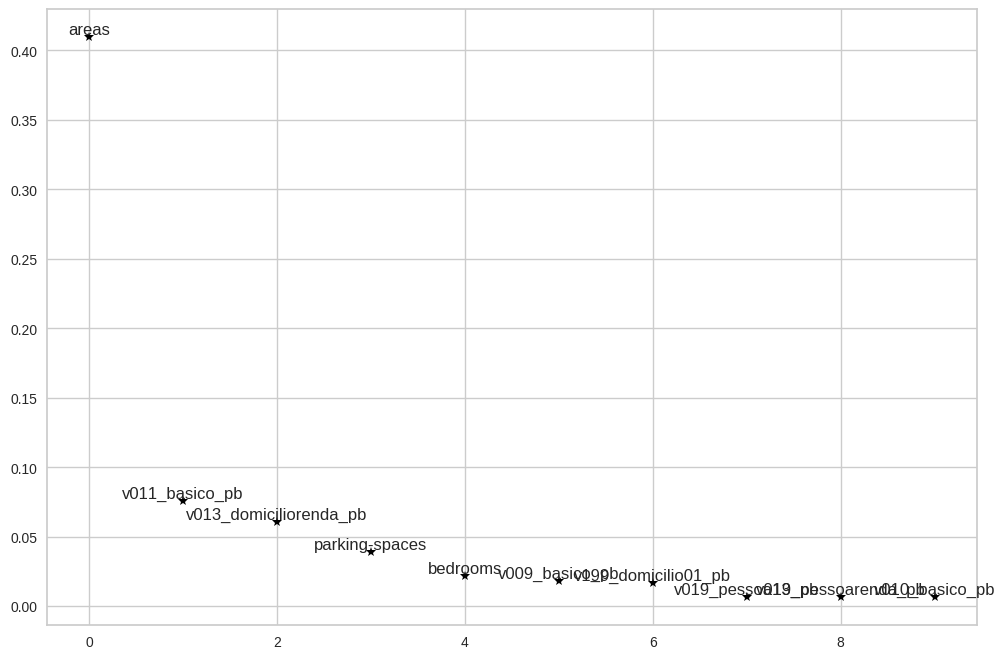

In [234]:
fig_tree_explainer = plot_feature_importance(
    feature_importances, 
    10
)

## Plots

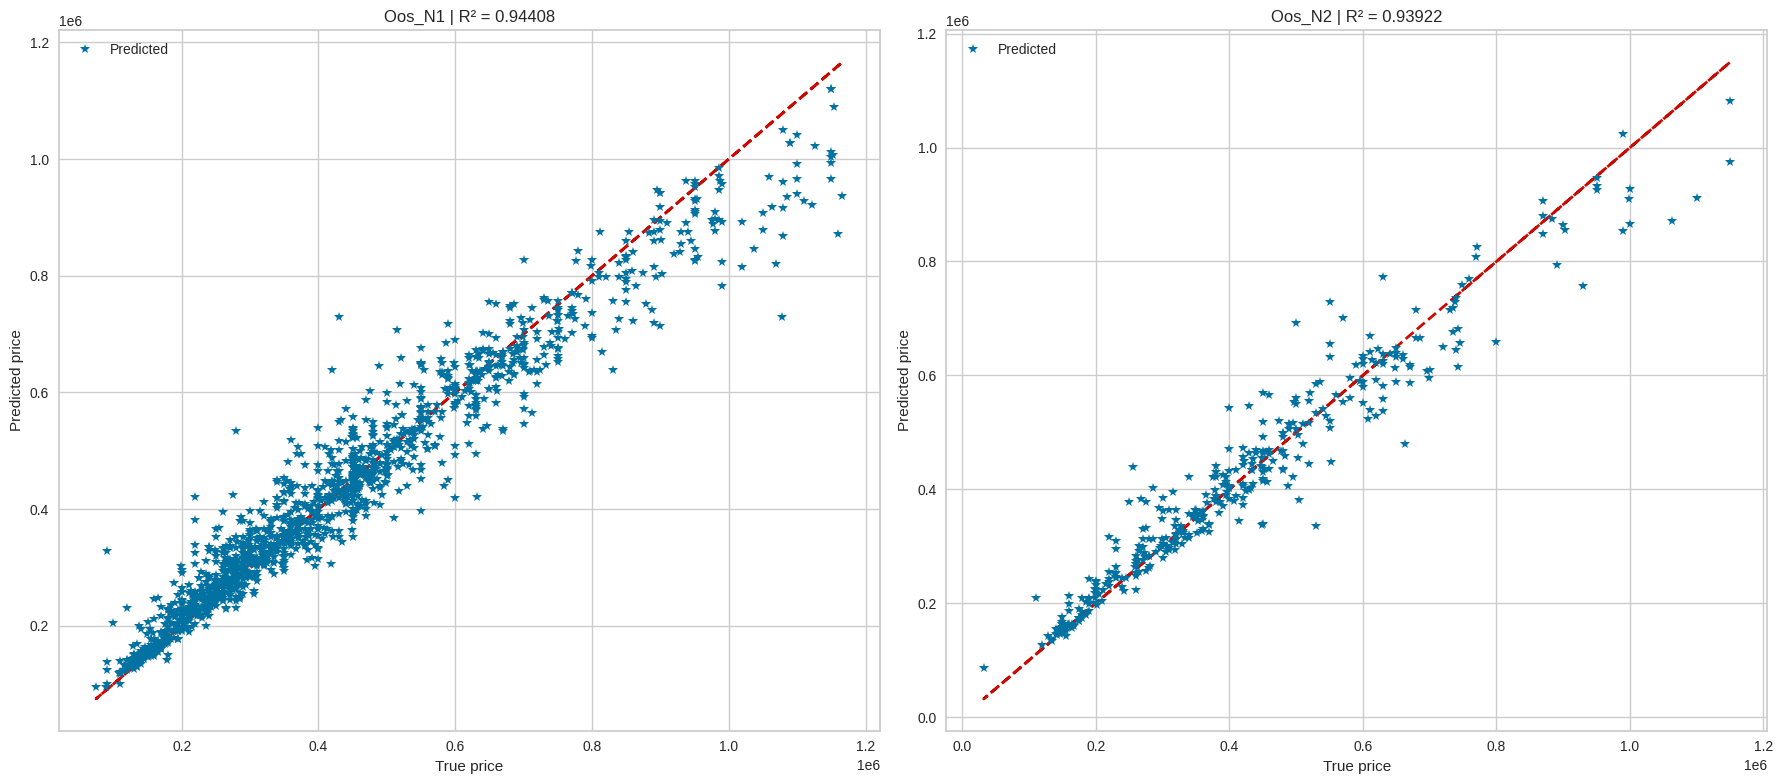

In [235]:
fig_predicts = plot_predictions(
    data_values,
    metrics_results,
    target,
    figsize = (18, 8)
)

2
2


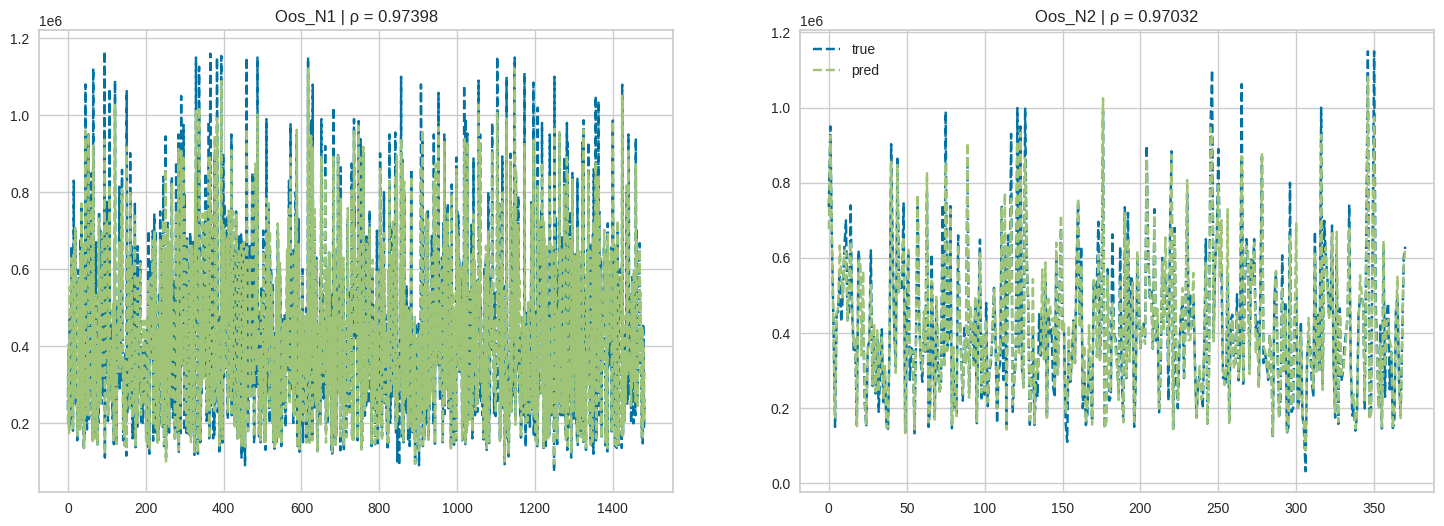

In [236]:
fig_true_vs_pred = plot_true_vs_pred(
    data_values,
    None,
    None,
    figsize = (18, 6),
    linestyle = 'dashed'
)

In [237]:
data_values["oos_n1"]

,y_true,y_pred,rank_true,rank_pred
0,235000.0,199073.190476,1168,1296
1,390000.0,397075.006643,715,711
2,389000.0,404579.281667,717,701
3,180000.0,173937.237500,1311,1343
4,198000.0,208277.000000,1272,1283
...,...,...,...,...
1477,147000.0,162687.900000,1410,1369
1478,458000.0,408280.523333,532,692
1479,414240.0,379705.470000,666,753
1480,185000.0,204003.485714,1298,1290
